<h1>Test cases for the graylevelcooccurence matrix function adaption for 3D</h1>
The function is tested by using an adaption that only calculates the glcm's for 1 pixel to simplify and compare with cases where we already know what glcm we would expect

In [163]:
import numpy as np
from matplotlib import pyplot as plt
import skimage
from skimage.draw import ellipsoid
import pandas as pd


In [164]:
def graycomatrix_3d_test(img:np.ndarray, distances:float, angles_1, angles_2, start):

    #same as graycomatrix_3d but with tested using only the center-pixel of the image
    
    def calc_offset(angle_pair, distance:float):
        z:float = np.multiply(distance, np.sin(angle_pair[1]), dtype=float)
        x2:float = np.multiply(np.multiply(distance, np.cos(angle_pair[1]),dtype=float), np.sin(angle_pair[0]),dtype=float)
        y2:float = np.multiply(np.multiply(distance, np.cos(angle_pair[1]),dtype=float), np.cos(angle_pair[0]),dtype=float)
        return(np.array([int(z),int(x2),int(y2)], dtype=int))
    
    img:int = (np.rint(img)).astype(int)
    levels:int = img.max() + 1 
    
    grid1, grid2 = np.meshgrid(angles_1, angles_2)
    angles:int = np.vstack([grid1.ravel(), grid2.ravel()]).T
    
    # Get the shape of the image
    z_max:int  = img.shape[0]-1
    x_max:int = img.shape[1]-1
    y_max:int = img.shape[2]-1

    z,x,y = start

    glcm:int = np.zeros((levels, levels, len(distances), len(angles)), dtype=int)

    for i,distance in enumerate(distances):
        for j,angle_pair in enumerate(angles):
            offset = calc_offset(angle_pair, distance)
            curr = np.array([z,x,y], dtype=int)
            neighbor = np.add(curr,offset, dtype=int)
            if neighbor[1] >= 0 and neighbor[1] < x_max and neighbor[2] >= 0 and neighbor[2] < y_max and neighbor[0] >= 0 and neighbor[0] < z_max:
                glcm[img[z,x,y], img[neighbor[0],neighbor[1],neighbor[2]], i, j] += 1
            else:
                continue
    
    return(glcm)


def sum_glcm(glcm):
    df_prev = pd.DataFrame(np.zeros((2,2)))
    for angle in range(glcm.shape[3]):
        df_curr=pd.DataFrame(glcm[:,:,0,angle])
        df_prev = df_curr+df_prev
    return(df_prev)

In [165]:
#create sphere and pad so shifting sphere doesn't result in out of bounds error or too early reintroduction of sphere on the other side
radius = 300
offset = 15
sphere = ellipsoid(radius, radius, radius)

sphere = np.pad(sphere, ((offset*3, offset*3), (offset*3, offset*3), (offset*3, offset*3)), mode='constant')


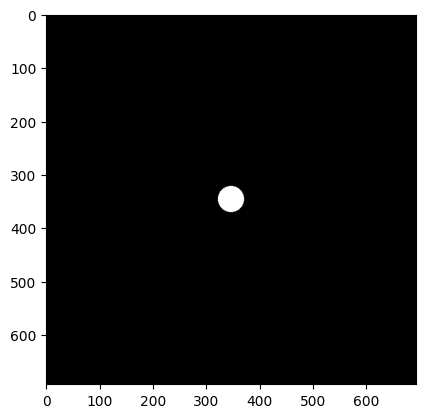

In [166]:
plt.imshow(sphere[(sphere.shape[0]-1)//2-radius+1], cmap='gray')
plt.imshow(sphere[(sphere.shape[0]-1)//2+radius-1], cmap='gray')

#print(sphere[start[0]+radius,start[1],start[2]])


In [201]:
angles = np.arange(12)
angles = angles * np.pi / 12
grid1, grid2 = np.meshgrid(angles, angles)
combinations:int = np.vstack([grid1.ravel(), grid2.ravel()]).T

#distance 300 of 300x300x300 sphere, only 1-1 cooccurences

start = [(sphere.shape[0]-1)//2, (sphere.shape[1]-1)//2, (sphere.shape[2]-1)//2]
print(start, sphere.shape)

glcm = graycomatrix_3d_test(sphere, distances=[radius], angles_1=angles, angles_2=angles, start=start)

sum_glcm(glcm)

[346, 346, 346] (693, 693, 693)


,0,1
0,0.0,0.0
1,0.0,144.0


In [168]:
#distance 300 of 300x300x300 sphere, origin shifted by 1 pixel, not only 1-1 cooccurences

start = [(sphere.shape[0])//2-1, (sphere.shape[1])//2-1, (sphere.shape[2])//2-1]

glcm = graycomatrix_3d_test(sphere, distances=[radius], angles_1=angles, angles_2=angles, start=start)

sum_glcm(glcm)


,0,1
0,0.0,0.0
1,1.0,143.0


In [208]:
#distance 300 of 300x300x300 sphere, origin shifted by radius -> ratio of 0-1 cooccurences to total cooccurences should be equal to the volume of the cone formed by the intersection
start = [(sphere.shape[0])//2-radius, (sphere.shape[1])//2, (sphere.shape[2])//2]

glcm = graycomatrix_3d_test(sphere, distances=[radius], angles_1=angles, angles_2=angles, start=start)

glcm = sum_glcm(glcm)
print(glcm)

ratio_conevolume_volume = glcm[0][1]/(glcm.sum().sum())
print(ratio_conevolume_volume)




0.3055555555555556

In [204]:
#volume of the cone formed by the intersection of the sphere and the halfsphere
(np.pi * radius**2 * (radius/(np.sqrt(3) * 3))) / (sphere.sum() /2)

0.2886822574529649

In [169]:
#distance 301 of 300x300x300 sphere, origin not shifted, only 1-0 cooccurences in theory
#some 1-1 cooccurences since calculation of offset(in glcm function) is not perfect and always rounds down (truncates to int)
start = [(sphere.shape[0]-1)//2, (sphere.shape[1]-1)//2, (sphere.shape[2]-1)//2]

glcm = graycomatrix_3d_test(sphere, distances=[radius+1], angles_1=angles, angles_2=angles, start=start)

sum_glcm(glcm)


,0,1
0,0.0,0.0
1,98.0,46.0


In [200]:
#distance 302 of 300x300x300 sphere, origin not shifted, only 0-1 cooccurences in theory
#rounding down doesn't result in faulty 1-1 cooccurences
start = [(sphere.shape[0]-1)//2, (sphere.shape[1]-1)//2, (sphere.shape[2]-1)//2]

glcm = graycomatrix_3d_test(sphere, distances=[radius+2], angles_1=angles, angles_2=angles, start=start)

sum_glcm(glcm)



,0,1
0,0.0,0.0
1,144.0,0.0


Calculating the intersection of a shifted half sphere with a sphere / volume ratio of the half sphere should be equal as the ratio of 1-1 cooccurences / all cooccurences ....

the ratio didn't show to be perfectly equal but with increasing resolution (adding more angle pair), the ratio of the glcm got closer to the expected ratio

In [190]:
# Shifted sphere

offset=15
shifted_sphere = np.roll(sphere, offset, axis=0)
half_sphere = sphere.copy()
half_sphere[:(half_sphere.shape[0]-1)//2, :, :] = 0
# Intersection
intersection = (half_sphere & shifted_sphere).sum()
volume = half_sphere.sum()

int_ratio = intersection/volume

print(int_ratio)


0.9999493372752885


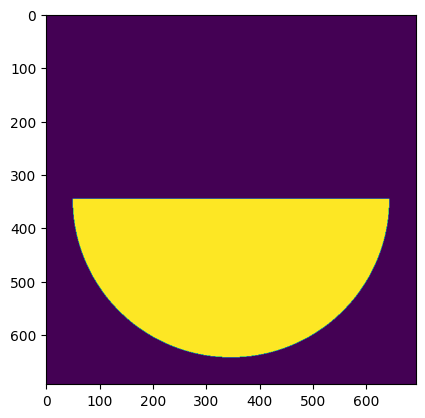

In [196]:
plt.imshow(half_sphere[:,:,300])
#checking if sphere is halfed correctly

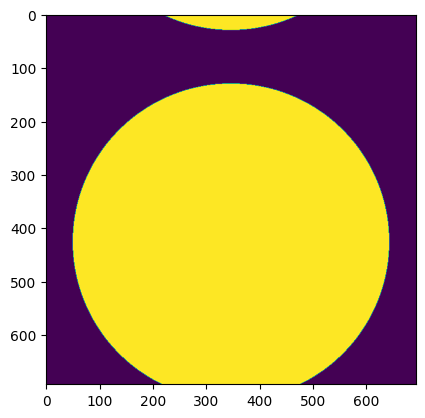

In [186]:
plt.imshow(shifted_sphere[:,:,300])
#checking if sphere is shefted correctly

In [193]:
#distance 30 of 30x30x30 sphere, origin shifted by 15 pixels, not only 1-1 cooccurences
start = [((sphere.shape[0]-1)//2-offset), (sphere.shape[1]-1)//2, (sphere.shape[2]-1)//2]

angles = np.arange(12)
angles = angles * np.pi / 12
grid1, grid2 = np.meshgrid(angles, angles)
combinations:int = np.vstack([grid1.ravel(), grid2.ravel()]).T

glcm = graycomatrix_3d_test(sphere, distances=[radius], angles_1=angles, angles_2=angles, start=start)

glcm = sum_glcm(glcm)
print(glcm)

print('-'*15)

int_ratio_glcm = glcm[1][1]/(glcm.sum().sum())
print(int_ratio_glcm)

     0      1
0  0.0    0.0
1  4.0  140.0
---------------
0.9722222222222222


In [194]:
#distance 30 of 30x30x30 sphere, origin shifted by 15 pixels, not only 1-1 cooccurences
start = [((sphere.shape[0]-1)//2-offset), (sphere.shape[1]-1)//2, (sphere.shape[2]-1)//2]

angles = np.arange(64)
angles = angles * np.pi / 64
grid1, grid2 = np.meshgrid(angles, angles)
combinations:int = np.vstack([grid1.ravel(), grid2.ravel()]).T

glcm = graycomatrix_3d_test(sphere, distances=[radius], angles_1=angles, angles_2=angles, start=start)

glcm = sum_glcm(glcm)
print(glcm)

print('-'*15)

int_ratio_glcm = glcm[1][1]/(glcm.sum().sum())
print(int_ratio_glcm)

      0       1
0   0.0     0.0
1  20.0  4076.0
---------------
0.9951171875


In [191]:
#distance 30 of 30x30x30 sphere, origin shifted by 15 pixels, not only 1-1 cooccurences
start = [((sphere.shape[0]-1)//2-offset), (sphere.shape[1]-1)//2, (sphere.shape[2]-1)//2]

angles = np.arange(512)
angles = angles * np.pi / 512
grid1, grid2 = np.meshgrid(angles, angles)
combinations:int = np.vstack([grid1.ravel(), grid2.ravel()]).T

glcm = graycomatrix_3d_test(sphere, distances=[radius], angles_1=angles, angles_2=angles, start=start)

glcm = sum_glcm(glcm)
print(glcm)

print('-'*15)

int_ratio_glcm = glcm[1][1]/(glcm.sum().sum())
print(int_ratio_glcm)

       0         1
0    0.0       0.0
1  360.0  261784.0
---------------
0.998626708984375


In [195]:
#distance 30 of 30x30x30 sphere, origin shifted by 15 pixels, not only 1-1 cooccurences
start = [((sphere.shape[0]-1)//2-offset), (sphere.shape[1]-1)//2, (sphere.shape[2]-1)//2]

angles = np.arange(512*4)
angles = angles * np.pi / (512*4)
grid1, grid2 = np.meshgrid(angles, angles)
combinations:int = np.vstack([grid1.ravel(), grid2.ravel()]).T

glcm = graycomatrix_3d_test(sphere, distances=[radius], angles_1=angles, angles_2=angles, start=start)

glcm = sum_glcm(glcm)
print(glcm)

print('-'*15)

int_ratio_glcm = glcm[1][1]/(glcm.sum().sum())
print(int_ratio_glcm)

        0          1
0     0.0        0.0
1  5676.0  4188628.0
---------------
0.9986467361450195
